In [8]:
import pandas as pd
import numpy as np
import re

# 1. Setup path and load data
path = r"C:\Users\aljha\Downloads\Animal Dataset.csv"
df = pd.read_csv(path)

print("--- Data Before Cleaning ---")
display(df.head())

# 2. Robust cleaning function (removes commas, units, and handles ranges)
def clean_numeric(value):
    if pd.isna(value) or str(value).lower() in ['varies', 'unknown', 'not applicable', 'none']:
        return np.nan
    
    # Remove everything except digits, dots, and hyphens (fixes the '1,000' and 'kg' issues)
    text = re.sub(r'[^0-9.\-]', '', str(value))
    
    if '-' in text:
        try:
            parts = text.split('-')
            nums = [float(p) for p in parts if p.strip() != '']
            return sum(nums) / len(nums) if nums else np.nan
        except:
            return np.nan
    try:
        return float(text)
    except:
        return np.nan

# Apply cleaning to numeric columns
numeric_cols = ['Height (cm)', 'Weight (kg)', 'Lifespan (years)', 'Average Speed (km/h)', 'Gestation Period (days)', 'Top Speed (km/h)']
for col in numeric_cols:
    df[col] = df[col].apply(clean_numeric)

# Impute missing values with the mean of each column
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Save the cleaned file for later use
df.to_csv("Cleaned_Animal_Data.csv", index=False)
print("\n--- Cleaning successful. File saved as 'Cleaned_Animal_Data.csv' ---")
display(df[numeric_cols].head())

--- Data Before Cleaning ---


,Animal,Height (cm),Weight (kg),Color,Lifespan (years),Diet,Habitat,Predators,Average Speed (km/h),Countries Found,Conservation Status,Family,Gestation Period (days),Top Speed (km/h),Social Structure,Offspring per Birth
0,Aardvark,105-130,40-65,Grey,20-30,Insectivore,"Savannas, Grasslands","Lions, Hyenas",40,Africa,Least Concern,Orycteropodidae,210-240,40,Solitary,1
1,Aardwolf,40-50,8-14,Yellow-brown,10-12,Insectivore,"Grasslands, Savannas","Lions, Leopards",24-30,Eastern and Southern Africa,Least Concern,Hyaenidae,90,40,Solitary,2-5
2,African Elephant,270-310,2700-6000,Grey,60-70,Herbivore,"Savannah, Forest","Lions, Hyenas",25,Africa,Vulnerable,Elephantidae,640-660,40,Herd-based,1
3,African Lion,80-110,120-250,Tan,10-14,Carnivore,"Grasslands, Savannas","Hyenas, Crocodiles",58,Africa,Vulnerable,Felidae,98-105,80,Group-based,2-4 (usually)
4,African Wild Dog,75-80,18-36,Multicolored,10-12,Carnivore,Savannahs,"Lions, Hyenas",56,Sub-Saharan Africa,Endangered,Canidae,70,56,Group-based,10-12



--- Cleaning successful. File saved as 'Cleaned_Animal_Data.csv' ---


,Height (cm),Weight (kg),Lifespan (years),Average Speed (km/h),Gestation Period (days),Top Speed (km/h)
0,117.5,52.5,25.0,40.0,225.0,40.0
1,45.0,11.0,11.0,27.0,90.0,40.0
2,290.0,4350.0,65.0,25.0,650.0,40.0
3,95.0,185.0,12.0,58.0,101.5,80.0
4,77.5,27.0,11.0,56.0,70.0,56.0


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# 1. Data Preparation
le = LabelEncoder()
df['Diet_Label'] = le.fit_transform(df['Diet'])

X = df[numeric_cols]
y = df['Diet_Label']

# Split data: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Standardize data (Required for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Model 1: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_acc = accuracy_score(y_test, rf_model.predict(X_test))

# 3. Model 2: Support Vector Machine (SVC)
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_acc = accuracy_score(y_test, svm_model.predict(X_test_scaled))

# 4. Comparison and Selection
print(f"Random Forest Accuracy: {rf_acc:.2f}")
print(f"SVM Accuracy: {svm_acc:.2f}")

if rf_acc >= svm_acc:
    best_model = rf_model
    best_name = "Random Forest"
    final_X_test = X_test
else:
    best_model = svm_model
    best_name = "SVM"
    final_X_test = X_test_scaled

print(f"\n--- Best Model Selected: {best_name} ---")

# Final Evaluation Report
y_pred = best_model.predict(final_X_test)
unique_labels = np.unique(np.concatenate([y_test, y_pred]))
print(classification_report(y_test, y_pred, labels=unique_labels, target_names=le.inverse_transform(unique_labels)))

Random Forest Accuracy: 0.39
SVM Accuracy: 0.41

--- Best Model Selected: SVM ---
                        precision    recall  f1-score   support

             Carnivore       0.36      0.71      0.48        14
Carnivore, Insectivore       0.00      0.00      0.00         2
  Carnivore, Piscivore       0.00      0.00      0.00         1
  Carnivore, Scavenger       0.00      0.00      0.00         1
             Herbivore       0.54      0.70      0.61        10
Herbivore, Insectivore       0.00      0.00      0.00         1
           Insectivore       0.00      0.00      0.00         1
Insectivore, Herbivore       0.00      0.00      0.00         1
              Omnivore       0.00      0.00      0.00         9
 Omnivore, Insectivore       0.00      0.00      0.00         1

              accuracy                           0.41        41
             macro avg       0.09      0.14      0.11        41
          weighted avg       0.25      0.41      0.31        41



c:\Users\aljha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\aljha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\aljha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

C:\Users\aljha\AppData\Local\Temp\ipykernel_27052\1661947263.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Diet', order=df['Diet'].value_counts().index, palette='viridis')


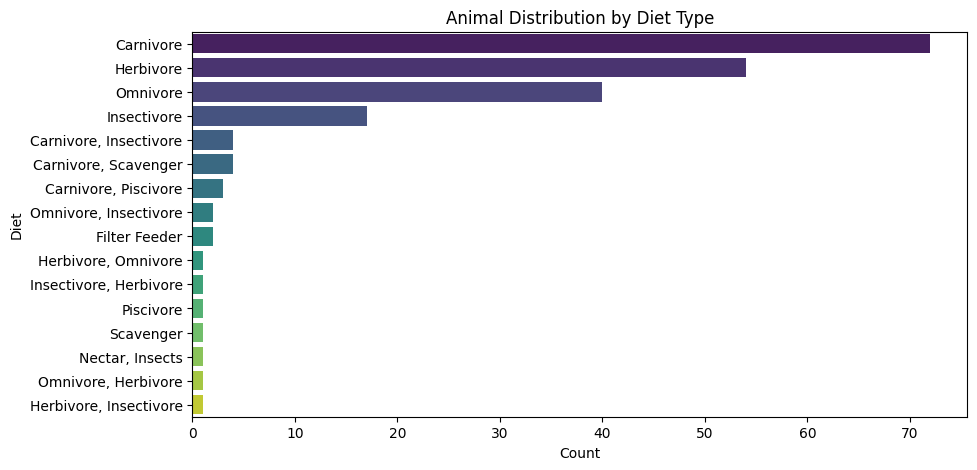

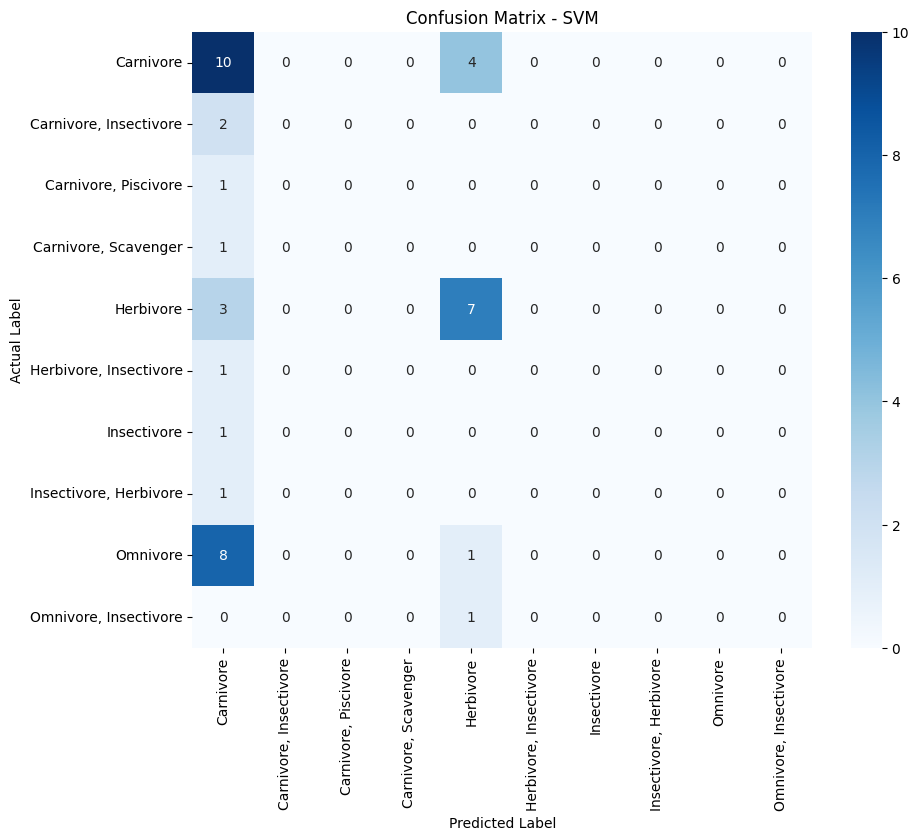

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Diet Distribution Plot
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y='Diet', order=df['Diet'].value_counts().index, palette='viridis')
plt.title('Animal Distribution by Diet Type')
plt.xlabel('Count')
plt.ylabel('Diet')
plt.show()

# 2. Confusion Matrix for the Best Model
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.inverse_transform(unique_labels), 
            yticklabels=le.inverse_transform(unique_labels))
plt.title(f'Confusion Matrix - {best_name}')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. Feature Importance (Only if Random Forest is the best model)
if best_name == "Random Forest":
    importances = best_model.feature_importances_
    feat_importances = pd.Series(importances, index=numeric_cols)
    plt.figure(figsize=(10, 5))
    feat_importances.nlargest(10).plot(kind='barh', color='teal')
    plt.title('Top Features Influencing Animal Diet Prediction')
    plt.xlabel('Relative Importance')
    plt.show()